In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

# adding path to GPR_for_IM directory in order to import relevant scripts
import sys
sys.path.append('../')
import load_datacube as load
import cov_tools as cov

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

## ps_eor covariance code:

See: https://gitlab.com/flomertens/ps_eor/-/blob/master/doc/GPR%20theory%20and%20practice.ipynb

Text(0.5, 1.0, 'Matern covariance functions for different\nvalues of nu and length-scale,\ncompared to the covariance of a 21 cm EoR signal')

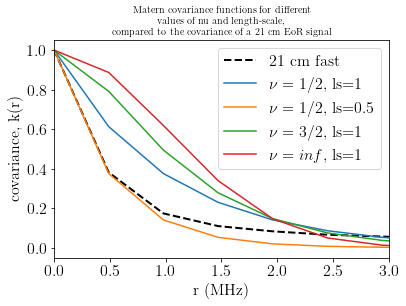

In [5]:
eor_cov_matrix = np.load('../Data/cov_matrix_eor_120-145.npy')
dx = 0.5

eor_bins, eor_cov = cov.get_cov_r(eor_cov_matrix, dx)
plt.plot(eor_bins, eor_cov, lw=2, c='k', ls='--', label='21 cm fast')
plt.plot(eor_bins, GPy.kern.Exponential(1).K_of_r(eor_bins / 1), label='$\\nu = 1/2$, ls=1')
plt.plot(eor_bins, GPy.kern.Exponential(1).K_of_r(eor_bins / 0.5), label='$\\nu = 1/2$, ls=0.5')
plt.plot(eor_bins, GPy.kern.Matern32(1).K_of_r(eor_bins / 1.), label='$\\nu = 3/2$, ls=1')
plt.plot(eor_bins, GPy.kern.RBF(1).K_of_r(eor_bins / 1.), label='$\\nu = inf$, ls=1')
#plt.plot(bins_21cmfast, cov_21cmfast,ls='dotted', lw=3, label='21cm FAST')

plt.xlim(0, 3)
plt.xlabel('r (MHz)')
plt.ylabel('covariance, k(r)')
plt.legend()
plt.title('Matern covariance functions for different\nvalues of nu and length-scale,\ncompared to the covariance of a 21 cm EoR signal', fontsize=10)

## Trying this on our 21cm data:

First, load the data in image form and then convert to visibility in order to compare the covariance matrix of the two.

In [6]:
# loading image data:
HI_data_wbeam = np.load('../Data/dT_HI_15mBeam.npy')#'Data/dT_HI-MDSAGE_z_0.39.npy'#'Data/dT_HI_15mBeam.npy'
HI_data_nobeam = np.load('../Data/dT_HI.npy')

# converting to visbility:
df = 1 # frequency resolution of data (MHz)
vmin = 899 # min frequency (MHz)
vmax = 1184 # max frequency (MHz)
nx = np.shape(HI_data_wbeam)[0]
ny = np.shape(HI_data_wbeam)[1] # number of pixels in nx and ny direction of data (equal in our case)
ra_width = dec_width = 54.1 # width of sky in RA and Dec directions (deg)
HI_data_wbeam_vis = load.generateCartDataCube(HI_data_wbeam, vmin, vmax, df, nx, ny, ra_width, dec_width)
HI_data_nobeam_vis = load.generateCartDataCube(HI_data_nobeam, vmin, vmax, df, nx, ny, ra_width, dec_width)

Calculate binned covariance matrix in image and visibility form.

In [7]:
# with beam:
bins_wbeam, cov_21wbeam = cov.binned_covariance(HI_data_wbeam, df)
bins_wbeam_vis, cov_21wbeam_vis = cov.binned_covariance(HI_data_wbeam_vis.data, df, vis=True)
# no beam:
bins_nobeam, cov_21nobeam = cov.binned_covariance(HI_data_nobeam, df)
bins_nobeam_vis, cov_21nobeam_vis = cov.binned_covariance(HI_data_nobeam_vis.data, df, vis=True)

In [8]:
# Checking 21cmFAST data:

# from astropy.io import fits
# hdul = fits.open('../Data/obs_units_lc_faintgals_new_lownu40.36_dnu0.50.fits')
# sim21cmfast_data = hdul[0].data
# sim21cmfast_data = np.swapaxes(sim21cmfast_data, 1, 2)
# sim21cmfast_data = np.swapaxes(sim21cmfast_data, 0, 2)
# bins_21cmfast, cov_21cmfast = cov.binned_covariance(sim21cmfast_data, 0.5)

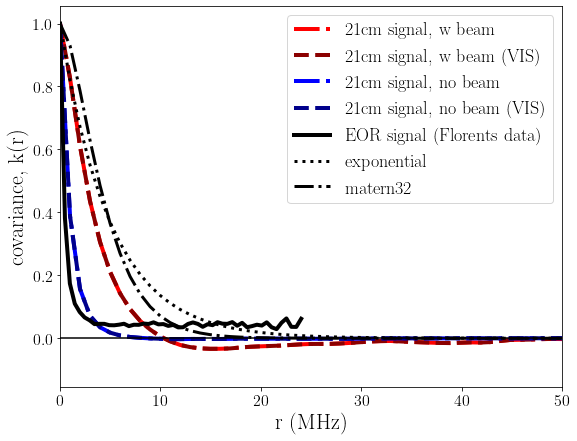

In [9]:
plt.figure(figsize=(9,7))

plt.plot(bins_wbeam, cov_21wbeam, lw=4, c='red', ls='dashdot', label='21cm signal, w beam')
plt.plot(bins_wbeam_vis, cov_21wbeam_vis, lw=4, c='darkred', ls='--', label='21cm signal, w beam (VIS)')
plt.plot(bins_nobeam, cov_21nobeam, lw=4, c='blue', ls='dashdot', label='21cm signal, no beam')
plt.plot(bins_nobeam_vis, cov_21nobeam_vis, lw=4, c='darkblue', ls='--', label='21cm signal, no beam (VIS)')
plt.plot(eor_bins, eor_cov, lw=4, c='k', ls='solid', label='EOR signal (Florents data)')
plt.plot(bins_wbeam, GPy.kern.Exponential(1).K_of_r(bins_wbeam / 5),lw=3,c='k',ls='dotted', label='exponential')
plt.plot(bins_wbeam, GPy.kern.Matern32(1).K_of_r(bins_wbeam / 4),lw=3,c='k',ls='dashdot', label='matern32')
#plt.plot(bins_21cmfast, cov_21cmfast,ls='dotted', lw=5, label='21cm FAST')

plt.axhline(0, c='k')

plt.xlim(0, 50)
plt.xlabel('r (MHz)', fontsize=22)
plt.ylabel('covariance, k(r)', fontsize=22)
plt.legend(fontsize=18)

### Trying FG data (no pol)

First, load data and covnert to visibilities.

In [11]:
# loading image data:
HI_nobeam_path = '../Data/dT_HI.npy'
noise_nobeam_path = '../Data/dT_noise.npy'
FG_nopol_nobeam_path = '../Data/dT_FGnopol_Stripe82_noBeam.npy'
FGnopol_nobeam = np.load(HI_nobeam_path) + np.load(noise_nobeam_path) + np.load(FG_nopol_nobeam_path)
FGnopol_wbeam = np.load('../Data/dT_HI+noise+FGnopol_Stripe82_15mBeam_unsmoothednoise.npy')
# convert to visibilities:
FGnopol_nobeam_vis = load.generateCartDataCube(FGnopol_nobeam, vmin, vmax, df, nx, ny, ra_width, dec_width)
FGnopol_wbeam_vis = load.generateCartDataCube(FGnopol_wbeam, vmin, vmax, df, nx, ny, ra_width, dec_width)

Calculate binned covariance.

In [12]:
# with beam:
bins_wbeam, cov_FGwbeam = cov.binned_covariance(FGnopol_wbeam, df)
bins_wbeam_vis, cov_FGwbeam_vis = cov.binned_covariance(FGnopol_wbeam_vis.data, df, vis=True)
# no beam:
bins_nobeam, cov_FGnobeam = cov.binned_covariance(FGnopol_nobeam, df)
bins_nobeam_vis, cov_FGnobeam_vis = cov.binned_covariance(FGnopol_nobeam_vis.data, df, vis=True)

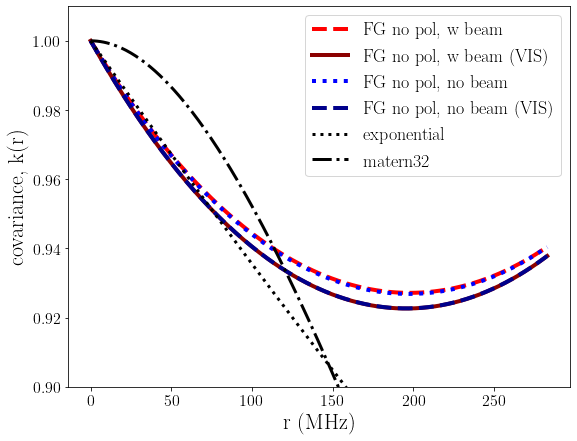

In [13]:
plt.figure(figsize=(9,7))

plt.plot(bins_wbeam, cov_FGwbeam, lw=4, c='red', ls='--', label='FG no pol, w beam')
plt.plot(bins_wbeam_vis, cov_FGwbeam_vis, lw=4, c='darkred', ls='solid', label='FG no pol, w beam (VIS)')
plt.plot(bins_nobeam, cov_FGnobeam, lw=4, c='blue', ls='dotted', label='FG no pol, no beam')
plt.plot(bins_nobeam_vis, cov_FGnobeam_vis, lw=4, c='darkblue', ls='--', label='FG no pol, no beam (VIS)')
plt.plot(bins_wbeam, GPy.kern.Exponential(1).K_of_r(bins_wbeam / 1500),lw=3,c='k',ls='dotted', label='exponential')
plt.plot(bins_wbeam, GPy.kern.Matern32(1).K_of_r(bins_wbeam / 500),lw=3,c='k',ls='dashdot', label='matern32')

plt.ylim(0.9,1.01)
plt.xlabel('r (MHz)', fontsize=22)
plt.ylabel('covariance, k(r)', fontsize=22)
plt.legend(fontsize=18)